In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


In [48]:
from scipy.stats import norm, skew
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')


In [49]:
train=pd.read_csv('../input/playground-series-s4e10/train.csv')
test=pd.read_csv('../input/playground-series-s4e10/test.csv')

In [50]:
print("train_size:{}".format(train.shape))
print("test_size:{}".format(test.shape))

train_size:(58645, 13)
test_size:(39098, 12)


In [51]:
train.head(20)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
5,5,27,45000,RENT,2.0,VENTURE,A,9000,8.94,0.20,N,5,0
6,6,25,45000,MORTGAGE,9.0,EDUCATION,A,12000,6.54,0.27,N,3,0
7,7,21,20000,RENT,0.0,PERSONAL,C,2500,13.49,0.13,Y,3,0
8,8,37,69600,RENT,11.0,EDUCATION,D,5000,14.84,0.07,Y,11,0
9,9,35,110000,MORTGAGE,0.0,DEBTCONSOLIDATION,C,15000,12.98,0.14,Y,6,0


In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [54]:
test.head(20)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
5,58650,23,66000,RENT,5.0,EDUCATION,D,22000,14.09,0.33,N,2
6,58651,26,75000,OWN,10.0,PERSONAL,B,8000,10.62,0.11,N,4
7,58652,23,55000,MORTGAGE,6.0,PERSONAL,A,6250,6.76,0.12,N,2
8,58653,32,29124,RENT,0.0,PERSONAL,C,7200,13.11,0.26,Y,6
9,58654,22,90000,RENT,4.0,DEBTCONSOLIDATION,C,10000,13.49,0.11,Y,3


In [55]:
original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

In [56]:
original.head(20)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [57]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


I noticed that loan_int_rate have a strong correlation with loan_grade! So, I used the average value of each loan_grade to fill in loan_int_rate

In [58]:
# loan_int_rateの空白をNaNに置き換え
original['loan_int_rate'] = pd.to_numeric(original['loan_int_rate'], errors='coerce')

# loan_gradeごとにloan_int_rateの平均を計算
mean_rates = original.groupby('loan_grade')['loan_int_rate'].mean()

# loan_gradeごとの平均を用いて空白セルを埋める
for grade, mean_rate in mean_rates.items():
    original.loc[(original['loan_grade'] == grade) & (original['loan_int_rate'].isna()), 'loan_int_rate'] = mean_rate

# 結果を確認
print(original)

# 結果を新しいCSVファイルとして保存する
original.to_csv('filled_credit_risk_dataset.csv', index=False)

new_original = pd.read_csv('filled_credit_risk_dataset.csv')
new_original.head(100)

       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,23,120000,RENT,1.0,EDUCATION,B,25600,12.69,0,0.21,N,3
96,24,12360,OWN,2.0,MEDICAL,C,1600,13.57,0,0.13,N,3
97,22,60000,RENT,0.0,VENTURE,B,25475,10.99,1,0.42,N,3
98,25,234000,MORTGAGE,3.0,MEDICAL,C,20000,14.27,0,0.09,Y,4


In [59]:
missing_int_rate = new_original[new_original['loan_int_rate'].isna()]

print(missing_int_rate)

Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_status, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length]
Index: []


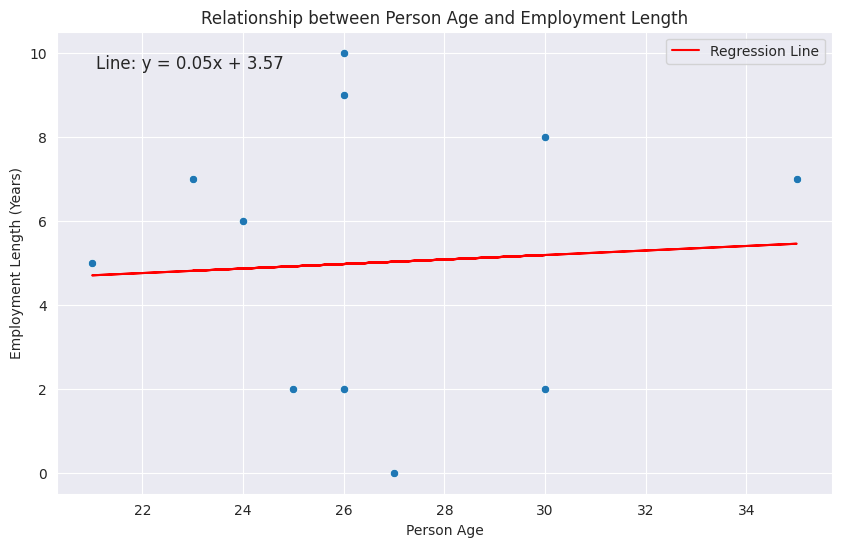

In [60]:
# ランダムに行をサンプリング
sampled_data = original.sample(n=12, random_state=42)

# 必要なカラムの抽出
data = sampled_data[['person_age', 'person_emp_length']]

# 相関図を作成
plt.figure(figsize=(10, 6))
sns.scatterplot(x='person_age', y='person_emp_length', data=data)

# 最小二乗法による線を計算
slope, intercept = np.polyfit(data['person_age'], data['person_emp_length'], 1)
line = slope * data['person_age'] + intercept

# 回帰直線をプロット
plt.plot(data['person_age'], line, color='red', label='Regression Line')

# 回帰式を表示
plt.text(0.05, 0.95, f'Line: y = {slope:.2f}x + {intercept:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# タイトルとラベルを設定
plt.title('Relationship between Person Age and Employment Length')
plt.xlabel('Person Age')
plt.ylabel('Employment Length (Years)')
plt.legend()

# グリッドを追加
plt.grid(True)

# プロットを表示
plt.show()


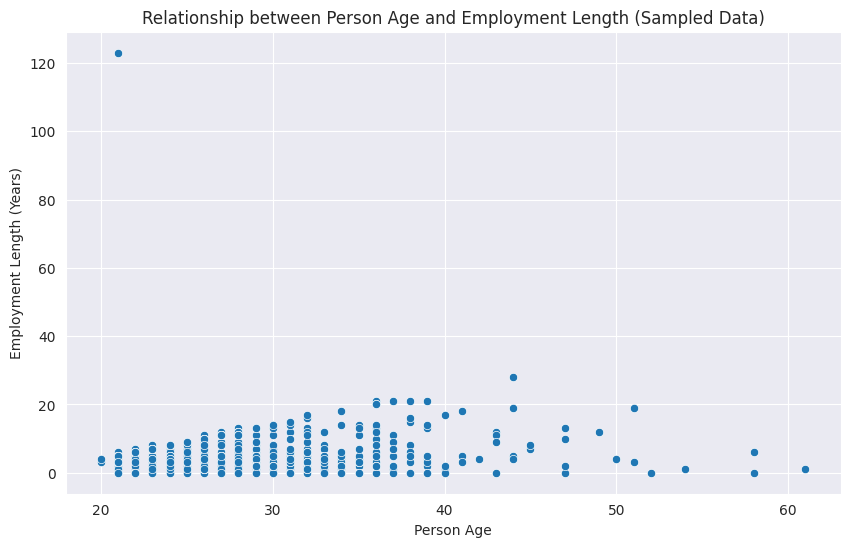

In [61]:
# ランダムに1000行をサンプリング
sampled_data = original.sample(n=1000, random_state=42)

# 必要なカラムの抽出
data = sampled_data[['person_age', 'person_emp_length']]

# 相関図を作成
plt.figure(figsize=(10, 6))
sns.scatterplot(x='person_age', y='person_emp_length', data=data)

# タイトルとラベルを設定
plt.title('Relationship between Person Age and Employment Length (Sampled Data)')
plt.xlabel('Person Age')
plt.ylabel('Employment Length (Years)')

# グリッドを追加
plt.grid(True)

# プロットを表示
plt.show()


I did not find the correlation between person_emp_length and person_age. So I just used average value to fill in.

In [62]:
new_original['person_emp_length'].fillna(new_original['person_emp_length'].mean(), inplace=True)

In [63]:
new_original.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [64]:
obj_cols = (['person_home_ownership', 'loan_intent', 'loan_grade',
            'cb_person_default_on_file'])
num_cols = (['person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
            'cb_person_cred_hist_length'])

features = obj_cols + num_cols 

In [65]:
train['label'] = 0
new_original['label'] = 1
target = 'label'

all_cols = features + [target]

In [66]:
train[all_cols].shape, new_original[all_cols].shape

((58645, 12), (32581, 12))

In [67]:
# Defining a function to create adversarial data: combines, shuffles, and re-splits the two datasets
# The resulting datasets include a mixture of the train and orignal data
def create_adversarial_data(train, new_original, cols, N_val=50000):
    combined_data = pd.concat([train[cols], new_original[cols]], axis=0)
    adversarial_test = combined_data.sample(N_val, replace=False)
    adversarial_train = combined_data.drop(adversarial_test.index)
    return adversarial_train, adversarial_test

# Applying function to train and orignal data, checking out the resulting shapes
adversarial_train, adversarial_test = create_adversarial_data(train, new_original, all_cols)
adversarial_train.shape, adversarial_test.shape

((25144, 12), (50000, 12))

In [68]:
# Setting up the Catboost model for adversarial validation
import catboost
from catboost import Pool, CatBoostClassifier

train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
    cat_features=obj_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
    cat_features=obj_cols
)

# Establishing parameters for the Catboost classifier
catboost_params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': 50,
    'verbose': 0
}

# Fitting the model to the data
model = CatBoostClassifier(**catboost_params)
_ = model.fit(train_data, eval_set=holdout_data)

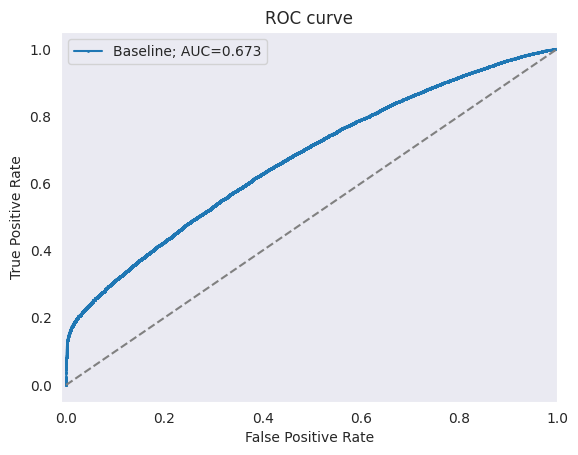

In [69]:
# Setting up ROC Curve plot
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, (y_true, y_pred) in enumerate(zip(y_trues, y_preds)): 
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label=f'{labels[i]}; AUC={auc_score:.3f}', marker='o', markersize=1)
    

    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--', color='grey') 
    ax.legend()
    ax.grid()
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    ax.set_ylabel('True Positive Rate')
    
# Plotting
plot_roc(
    y_trues=[holdout_data.get_label()],
    y_preds=[model.predict_proba(holdout_data)[:,1]],
    labels=['Baseline']
)

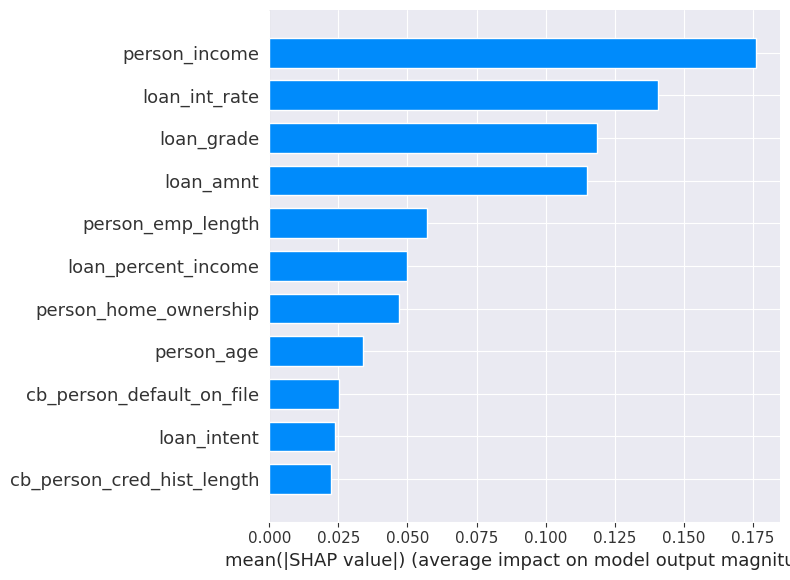

In [70]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import shap
shap.initjs()

# Defining function to plot feature importance
def plot_importances(model, holdout_data, features):
    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')
    
# Plotting feature importance
plot_importances(model, holdout_data, features)

In [71]:
# Removing 'person_income' and retraining the model
updated_params = catboost_params.copy()
updated_params['ignored_features'] = ['person_income']
model2 = CatBoostClassifier(**updated_params)
model2.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

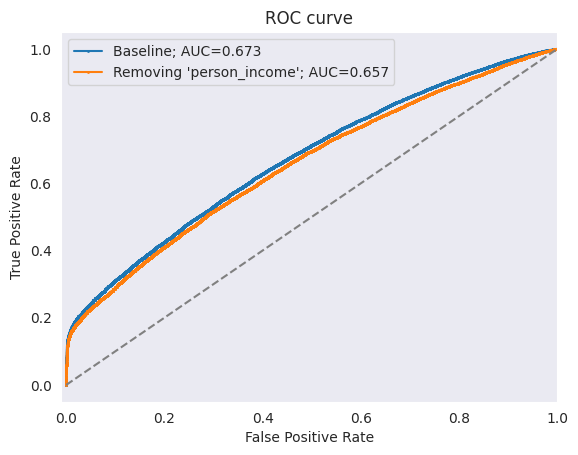

In [72]:
# Plotting updated ROC Curve plot
plot_roc(
    y_trues=[holdout_data.get_label()]*2,
    y_preds=[model.predict_proba(holdout_data)[:, 1], model2.predict_proba(holdout_data)[:, 1]],
    labels=['Baseline', "Removing 'person_income'"] 
)

In [73]:
# Removing 'loan_int_rate' and retraining the model
updated_params = catboost_params.copy()
updated_params['ignored_features'] = ['loan_int_rate']
model2 = CatBoostClassifier(**updated_params)
model2.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

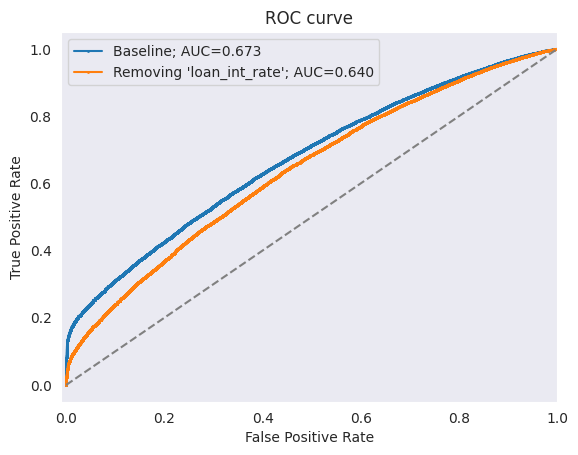

In [74]:
# Plotting updated ROC Curve plot
plot_roc(
    y_trues=[holdout_data.get_label()]*2,
    y_preds=[model.predict_proba(holdout_data)[:, 1], model2.predict_proba(holdout_data)[:, 1]],
    labels=['Baseline', "Removing 'loan_int_rate'"] 
)

AUC = 0.6 to 0.7, this is not close to 0.5 or 1,so the train data and the origin data do not have same distribution. let us remove ori data.

In [75]:
train=pd.read_csv('../input/playground-series-s4e10/train.csv')
test=pd.read_csv('../input/playground-series-s4e10/test.csv')

In [76]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score

In [77]:
obj_cols = (['person_home_ownership', 'loan_intent', 'loan_grade',
            'cb_person_default_on_file'])
num_cols = (['person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
            'cb_person_cred_hist_length'])

def preprocess_data(df, obj_cols, train=False):
    
    for col in obj_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')#0から4,294,967,295
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    df['person_age'] = df['person_age'].clip(None, 80)  #80以下でいいでしょう
    df['person_emp_length'] = df['person_emp_length'].clip(None, 65) #65以下でいいでしょう
    
    if train:

        df['loan_status'] = df['loan_status'].astype('int8')#0から255  0と1しかない時はint8
        
    return df
        
train = preprocess_data(train, obj_cols ,train=True)
test = preprocess_data(test, obj_cols)

RandomForestClassifier model

In [78]:
# 目的変数と特徴量の分割
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

# 交差検証の設定 (split数を5に)
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

# ダミー変数の作成
train_dummies = pd.get_dummies(X[obj_cols], drop_first=True, dtype='int8')
test_dummies = pd.get_dummies(test[obj_cols], drop_first=True, dtype='int8')

# 学習データとテストデータで同じカラムを持つようにする
train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1, fill_value=0)

# 元の数値データと結合
RF_train = pd.concat([X.drop(columns=obj_cols, axis=1), train_dummies], axis=1)
RF_test = pd.concat([test.drop(columns=obj_cols, axis=1), test_dummies], axis=1)


In [80]:
%%time

# randomサーチの設定（パラメータ範囲の絞り込み）
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# randomサーチの実行 (n_jobs=-1で並列処理を有効化)
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), param_dist, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=1)
random_search.fit(RF_train, Y)

# 最適なパラメータを表示
print("Best parameters found: ", random_search.best_params_)

# 最適なパラメータを使ってモデルを再学習
best_rf_md = random_search.best_estimator_

# スコアと予測結果のリスト
scores, rf_oof_preds, rf_test_preds = [], [], []

# 交差検証の実施
for i, (train_index, test_index) in enumerate(skf.split(RF_train, Y)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = RF_train.iloc[train_index], RF_train.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # 最適なモデルでの予測
    preds = best_rf_md.predict_proba(X_test)[:, 1]
    
    # 予測結果の格納
    oof_preds = pd.DataFrame({'y': y_test.values, 'rf_preds': preds, 'fold': i})
    rf_oof_preds.append(oof_preds)
    
    # ROC-AUCスコアの計算
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    # テストデータでの予測も格納
    test_preds = pd.DataFrame({'rf_preds': best_rf_md.predict_proba(RF_test)[:, 1], 'fold': i})
    rf_test_preds.append(test_preds)

# 最終的なスコアの計算
rf_oof_score = np.mean(scores)
rf_std = np.std(scores)
print(f"The 5-fold average oof ROC-AUC score of the RandomForest model is {rf_oof_score}")
print(f"The 5-fold std oof ROC-AUC score of the RandomForest model is {rf_std}")

# 重要な特徴量の確認
importances = best_rf_md.feature_importances_
features = RF_train.columns
important_features = pd.Series(importances, index=features).sort_values(ascending=False)
print(important_features.head(10))  # 上位10の重要な特徴量を表示


Best parameters found:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9478034089887627
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.947912108976202
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9427624321890069
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9460022990106872
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9407063594254973
The 5-fold average oof ROC-AUC score of the RandomForest model is 0.9450373217180312
The 5-fold std oof ROC-AUC score of the RandomForest model is 0.0028558423798592555
loan_percent_income           0.289113
loan_int_rate                 0.150533
loan_grade_D                  0.125283
person_home_ownership_RENT    0.100343
person_income                 0.087638
loan_amnt                     0.048972
person_emp_length             0.035896
loan_grad

LightGBM model

In [92]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# 目的変数と特徴量の分割
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

# LightGBMのパラメータ範囲を設定（パラメータ範囲をやや狭めて効率化）
lgb_param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],  # 探索範囲を少し狭く
    'n_estimators': [50, 100, 150],      # 木の数を減らす
    'max_depth': [5, 10, 15],            # 最大深さも減少
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'num_leaves': [20, 31, 40],          # 葉の数を減少
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# ランダムサーチの実行 (n_iterを15に減少、cv=3に減少)
random_search = RandomizedSearchCV(LGBMClassifier(n_jobs=-1, verbose=-1), lgb_param_dist, n_iter=15, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X, Y)

# 最適なパラメータを表示
print("Best parameters found: ", random_search.best_params_)

# 最適なパラメータでLGBMモデルを再学習（early stoppingを有効化）
best_lgb_params = random_search.best_params_
scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    # LightGBMモデルをcallbacksで早期終了を設定
    lgb_md = LGBMClassifier(**best_lgb_params)
    
    lgb_md.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        callbacks=[early_stopping(10), log_evaluation(0)]  # 10回改善しなければ終了
    )

    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

Best parameters found:  {'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
------------ Working on Fold 0 ------------
[LightGBM] [Info] Number of positive: 6680, number of negative: 40236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.940353	valid_0's binary_logloss: 0.252226
The oof ROC-AUC score is 0.9403525487051545
------------ Working on Fold 1 ------------
[LightGBM] [Info] Number of positive: 6680, numbe

In [87]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 目的変数と特徴量の分割
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

# ランダムサーチの結果から最適パラメータを適用
best_lgb_params = {
    'learning_rate': 0.09,
    'n_estimators': 200,
    'max_depth': 15,
    'reg_alpha': 0.25,
    'reg_lambda': 0.5,
    'num_leaves': 40,
    'colsample_bytree': 0.5,
    'verbose': -1,
    'n_jobs': -1
}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    # LGBMClassifierのearly_stoppingをcallbacksを使用して実装
    lgb_md = LGBMClassifier(**best_lgb_params)
    
    lgb_md.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # 検証用データをセット
        eval_metric='auc',            # AUCを評価基準に
        callbacks=[early_stopping(10), log_evaluation(0)]  # 10回改善しなければ終了
    )

    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")


------------ Working on Fold 0 ------------
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.95921	valid_0's binary_logloss: 0.143656
The oof ROC-AUC score is 0.9592104785359195
------------ Working on Fold 1 ------------
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.956156	valid_0's binary_logloss: 0.148527
The oof ROC-AUC score is 0.9561558660192291
------------ Working on Fold 2 ------------
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.960072	valid_0's binary_logloss: 0.141474
The oof ROC-AUC score is 0.9600724587210904
------------ Working on Fold 3 ------------
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.95816	valid_0's binary_logloss: 0.150228
The oof ROC-AUC score is 0.9581595532

Best parameters found:  {'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5}

CatBoost